In [14]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import pandas as pd
import shutil
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from skimage.feature import hog
from skimage.filters import gabor

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.model_selection import StratifiedKFold, cross_val_score

In [10]:
# dataset and output roots
dataset_folder = "/content/drive/MyDrive/makine_ogrenmesi/archive"
output_root_folder = "/content/out_ml"

In [2]:
def plot_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    print(counts)
    labels = ['Defect', 'No Defect']
    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title('Class Distribution')
    plt.show()

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return images

In [4]:
# Veri bölünmesi
def split_dataset(source_folder, output_root_folder):
  # Çıktı klasörleri yoksa oluştur.
  target_defect_folder = os.path.join(output_root_folder, "Defect_images")
  target_nodefect_folder = os.path.join(output_root_folder, "NODefect_images")
  os.makedirs(target_defect_folder, exist_ok=True)
  os.makedirs(target_nodefect_folder, exist_ok=True)

  # Kusurlu görüntüleri böl.
  defect_images_folder = os.path.join(source_folder, "Defect_images")

  # Kusurlu görüntüleri kopyala.
  for file_name in os.listdir(defect_images_folder):
    source_path = os.path.join(defect_images_folder, file_name)
    target_path = os.path.join(target_defect_folder, file_name)
    shutil.copy2(source_path, target_path)

  # Kusursuz görüntüleri kopyala.
  no_defect_images_folder = os.path.join(source_folder, "NODefect_images")
  for subfolder_name in os.listdir(no_defect_images_folder):
    subfolder_path = os.path.join(no_defect_images_folder, subfolder_name)
    if os.path.isdir(subfolder_path):
      for file_name in os.listdir(subfolder_path):
        source_path = os.path.join(subfolder_path, file_name)
        target_path = os.path.join(target_nodefect_folder, file_name)
        shutil.copy2(source_path, target_path)

In [5]:
# Veri ön işleme
def preprocess_data(defect_folder, nodefect_folder):
  defect_images = load_images_from_folder(defect_folder)
  nodefect_images = load_images_from_folder(nodefect_folder)

  # augmentation
  datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
  )

  augmented_images = []
  for img in defect_images:
    augmented_images.append(img)
    img = np.expand_dims(img, axis=0)
    it = datagen.flow(img, batch_size=1)
    for _ in range(4): # Her orijinal görüntü için 4 artırılmış görüntü.
      batch = it.next()
      augmented_img = batch[0].astype('uint8')
      augmented_images.append(augmented_img)

  # Kusurlu ve kusursuz görüntüleri birleştir.
  X = np.concatenate((augmented_images, nodefect_images))
  y = np.concatenate((np.ones(len(augmented_images)), np.zeros(len(nodefect_images))))

  # shuffle
  X, y = shuffle(X, y, random_state=57)

  return X, y

In [6]:
# Doku analizi özellikleri
def extract_texture_features(image):
  gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  features = []
  for x in range(0, image.shape[0], 16):
    for y in range(0, image.shape[1], 16):
      window = gray_img[x:x+16, y:y+16]
      features.append(np.mean(window))
      features.append(np.std(window))
      features.append(np.var(window))
  return features

# Renk analizi özellikleri
def extract_color_features(image):
  features = []
  for channel in range(0, 3):
    hist = cv2.calcHist([image], [channel], None, [256], [0, 255])
    features.extend(hist.flatten())
  return features

# Kontur analizi özellikleri
def extract_contour_features(image):
  gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  contours, hierarchy = cv2.findContours(gray_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  features = []
  for contour in contours:
    features.append(cv2.contourArea(contour))
    features.append(cv2.arcLength(contour, True))
  return features

# HOG özellik çıkarma
def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features, _ = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

# Renk histogramları özellik çıkarma
def extract_color_histograms(images):
    color_histograms = []
    for img in images:
        hist_r = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
        hist_g = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
        hist_b = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
        color_histograms.append(np.concatenate((hist_r, hist_g, hist_b)))
    return np.array(color_histograms)

# Gabor özellik çıkarma
def extract_gabor_features(images):
    gabor_features = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gabor_responses, _ = gabor(gray_img, frequency=0.6)
        gabor_features.append(gabor_responses.flatten())
    return np.array(gabor_features)

[115 421]


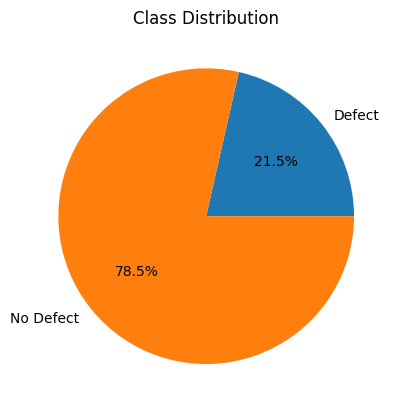

In [32]:
# Verileri hazırla
split_dataset(dataset_folder, output_root_folder)
defect_folder = os.path.join(output_root_folder, "Defect_images")
nodefect_folder = os.path.join(output_root_folder, "NODefect_images")

X, y = preprocess_data(defect_folder, nodefect_folder)

# Özellikleri çıkar
hog_features = extract_hog_features(X)
gabor_features = extract_gabor_features(X)
color_histogram_features = extract_color_histograms(X)
texture_features = [extract_texture_features(img) for img in X]
color_features = [extract_color_features(img) for img in X]
contour_features = [extract_contour_features(img) for img in X]

# Özellikleri birleştir
X_combined = np.concatenate((hog_features, gabor_features, color_histogram_features, texture_features, color_features, contour_features), axis=1)

# Veriyi karıştır
X_combined, y = shuffle(X_combined, y, random_state=57)

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

plot_class_distribution(y_train)

[414 414]


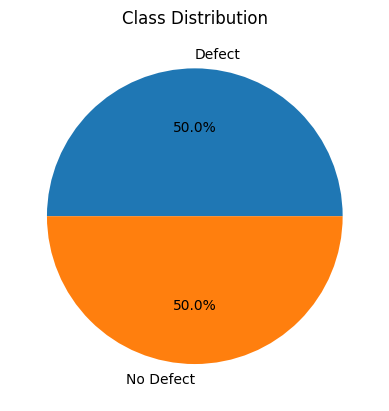

In [ ]:
smote = SMOTE(random_state=57)
X_train, y_train = smote.fit_resample(X_train.reshape(-1, 224 * 224 * 3), y_train)

X_train = X_train.reshape(-1, 224, 224, 3)

plot_class_distribution(y_train)

MODEL - **SVM**

In [ ]:
# SVM modelini eğitin
model = SVC(kernel='rbf', C=1, gamma='scale')
model.fit(X_train, y_train)

# Modeli değerlendirin
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8814814814814815


In [ ]:
# Evaluate the model of SVM
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.8814814814814815
              precision    recall  f1-score   support

         0.0       1.00      0.38      0.56        26
         1.0       0.87      1.00      0.93       109

    accuracy                           0.88       135
   macro avg       0.94      0.69      0.74       135
weighted avg       0.90      0.88      0.86       135



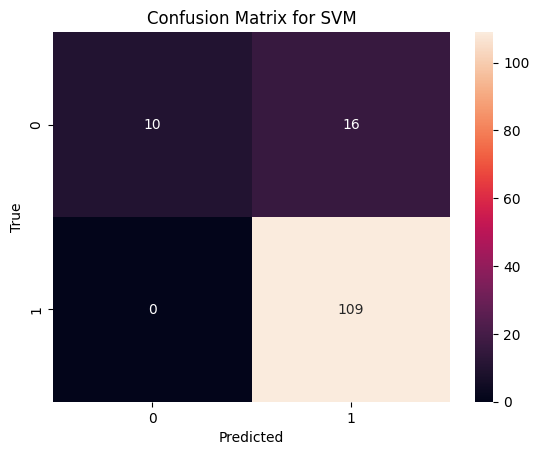

In [ ]:
# Confusion matrix for SVM
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM')
plt.show()

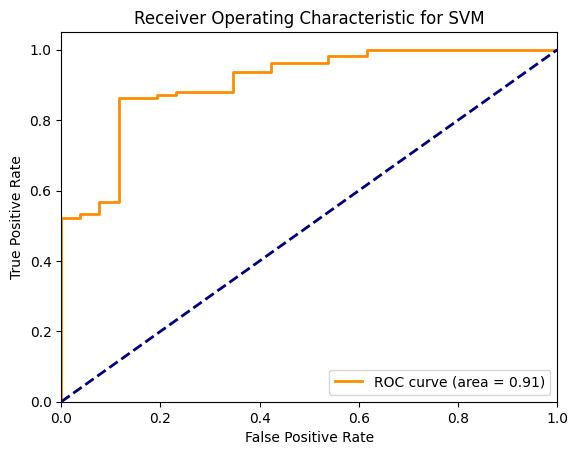

In [ ]:
# ROC Curve for SVM
y_pred_scores = model.decision_function(X_test)  # SVM için decision_function kullan
fpr, tpr, thresholds = roc_curve(y_test, y_pred_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

MODEL - **ADABOOST**

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Instantiate the model
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                               n_estimators=50,
                               learning_rate=1)

# Fit the model
ada_model.fit(X_train, y_train)

# Make predictions
y_pred = ada_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [34]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.837037037037037
              precision    recall  f1-score   support

         0.0       0.58      0.54      0.56        26
         1.0       0.89      0.91      0.90       109

    accuracy                           0.84       135
   macro avg       0.74      0.72      0.73       135
weighted avg       0.83      0.84      0.83       135



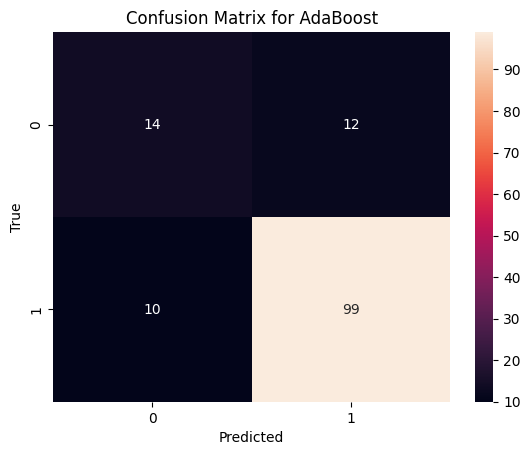

In [35]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for AdaBoost')
plt.show()

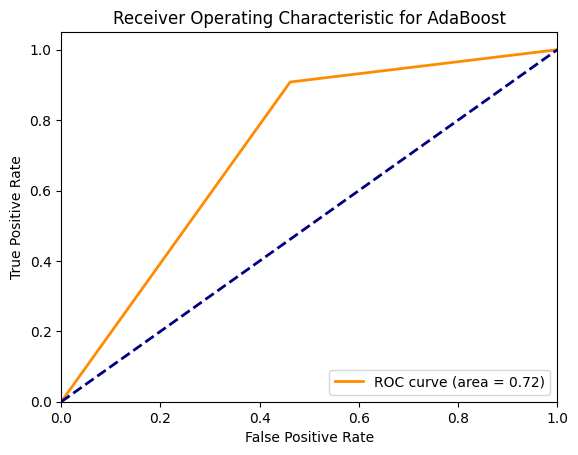

In [36]:
y_pred_proba = ada_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for AdaBoost')
plt.legend(loc="lower right")
plt.show()

MODEL - **XGBOOST VERSION 1**

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost modelini eğit
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=True)

# Tahminler yap
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.41201
[1]	validation_0-logloss:0.35964
[2]	validation_0-logloss:0.34161
[3]	validation_0-logloss:0.31319
[4]	validation_0-logloss:0.30382
[5]	validation_0-logloss:0.28982
[6]	validation_0-logloss:0.27500
[7]	validation_0-logloss:0.26846
[8]	validation_0-logloss:0.26086
[9]	validation_0-logloss:0.25095
[10]	validation_0-logloss:0.24513
[11]	validation_0-logloss:0.24158
[12]	validation_0-logloss:0.24285
[13]	validation_0-logloss:0.24481
[14]	validation_0-logloss:0.24433
[15]	validation_0-logloss:0.24860
[16]	validation_0-logloss:0.24738
[17]	validation_0-logloss:0.24848
[18]	validation_0-logloss:0.24744
[19]	validation_0-logloss:0.24779
[20]	validation_0-logloss:0.25246
[21]	validation_0-logloss:0.25219
[22]	validation_0-logloss:0.25355
[23]	validation_0-logloss:0.25032
[24]	validation_0-logloss:0.24846
[25]	validation_0-logloss:0.25022
[26]	validation_0-logloss:0.25090
[27]	validation_0-logloss:0.25016
[28]	validation_0-logloss:0.24895
[29]	validation_0-loglos

In [ ]:
# Modeli değerlendir
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.8740740740740741
              precision    recall  f1-score   support

         0.0       0.66      0.73      0.69        26
         1.0       0.93      0.91      0.92       109

    accuracy                           0.87       135
   macro avg       0.79      0.82      0.81       135
weighted avg       0.88      0.87      0.88       135



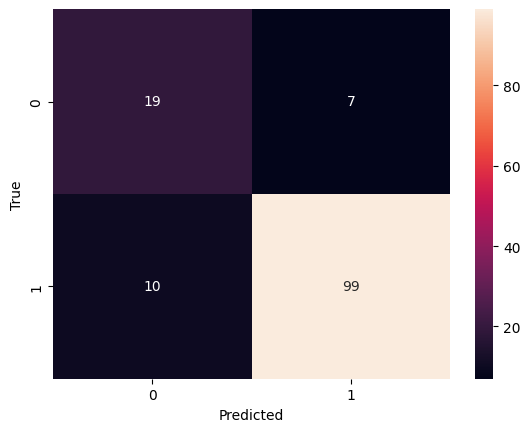

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

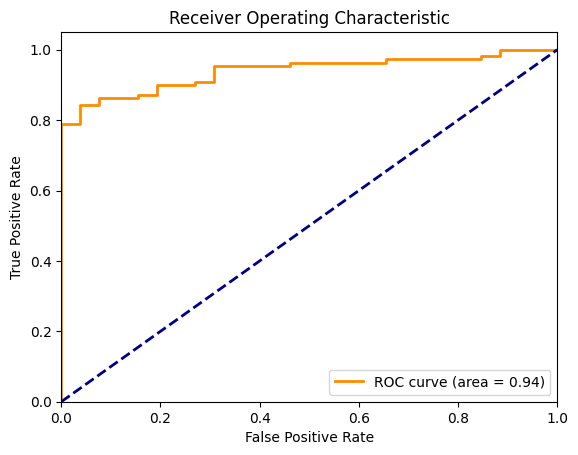

In [ ]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

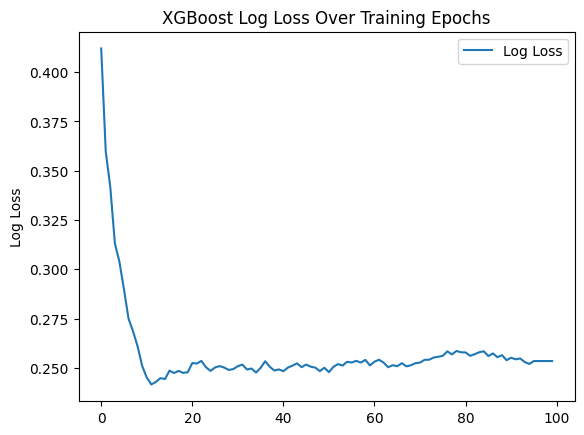

In [ ]:
# Eğitim kayıplarını görselleştir
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Log Loss')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Training Epochs')
plt.show()

MODEL - XGBOOST VERSION 2 - WITH EARLY STOPPING

In [ ]:
# XGBoost modelini eğit
model = XGBClassifier()
eval_set = [(X_test, y_test)]

# Early stopping ekleyelim
model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=True, early_stopping_rounds=10)

# Tahminler yap
y_pred = model.predict(X_test)

[0]	validation_0-logloss:0.41201
[1]	validation_0-logloss:0.35964
[2]	validation_0-logloss:0.34161
[3]	validation_0-logloss:0.31319
[4]	validation_0-logloss:0.30382
[5]	validation_0-logloss:0.28982
[6]	validation_0-logloss:0.27500
[7]	validation_0-logloss:0.26846
[8]	validation_0-logloss:0.26086
[9]	validation_0-logloss:0.25095
[10]	validation_0-logloss:0.24513
[11]	validation_0-logloss:0.24158
[12]	validation_0-logloss:0.24285
[13]	validation_0-logloss:0.24481
[14]	validation_0-logloss:0.24433
[15]	validation_0-logloss:0.24860
[16]	validation_0-logloss:0.24738
[17]	validation_0-logloss:0.24848
[18]	validation_0-logloss:0.24744
[19]	validation_0-logloss:0.24779
[20]	validation_0-logloss:0.25246


In [ ]:
# Modeli değerlendir
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.8740740740740741
              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68        26
         1.0       0.93      0.92      0.92       109

    accuracy                           0.87       135
   macro avg       0.80      0.80      0.80       135
weighted avg       0.88      0.87      0.87       135



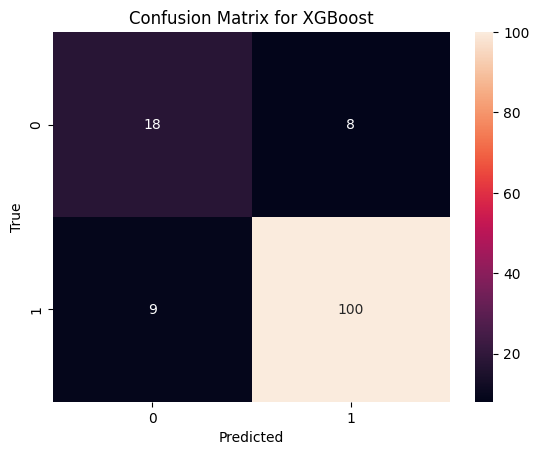

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost')
plt.show()

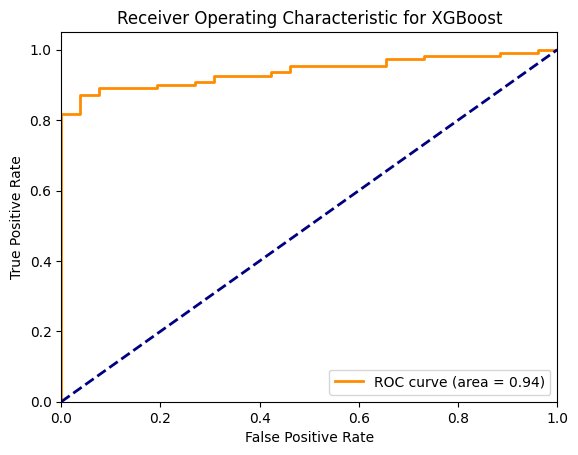

In [ ]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Eğitim kayıplarını görselleştir
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])

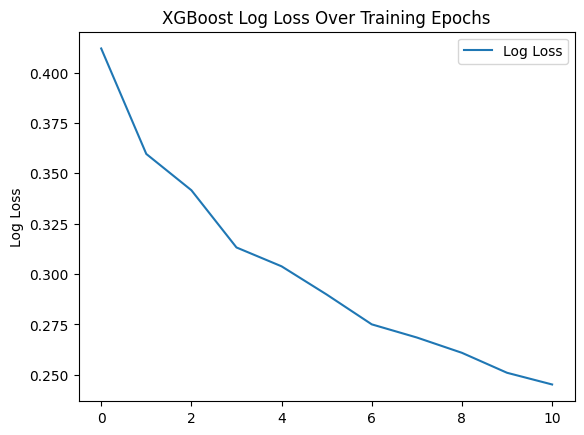

In [ ]:
# Early stopping'de duran epoch'u bul
early_stopping_rounds = model.best_iteration

x_axis = range(0, early_stopping_rounds)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'][:early_stopping_rounds], label='Log Loss')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Training Epochs')
plt.show()

MODEL -XGBOOST - VERSION 3 (FINAL XGBOOST EDITION)

In [ ]:
#another xgboost model
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

# XGBoost modelini oluşturun
xgb_model = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    scale_pos_weight=1,
    random_state=42
)

# Cross-validation için StratifiedKFold kullanarak modelin performansını değerlendirin
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Modeli eğitin
xgb_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapın
y_pred = xgb_model.predict(X_test)

Cross-Validation Scores: [0.89814815 0.90654206 0.90654206 0.89719626 0.86915888]
Mean Accuracy: 0.8955174800969194


In [20]:
# Modelin performansını değerlendirin
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9259259259259259
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81        26
         1.0       0.95      0.95      0.95       109

    accuracy                           0.93       135
   macro avg       0.88      0.88      0.88       135
weighted avg       0.93      0.93      0.93       135



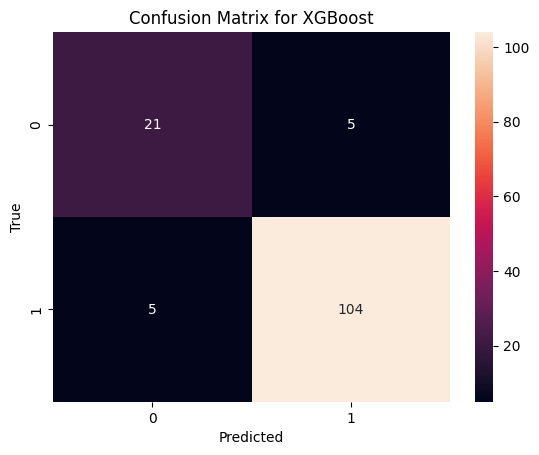

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost')
plt.show()

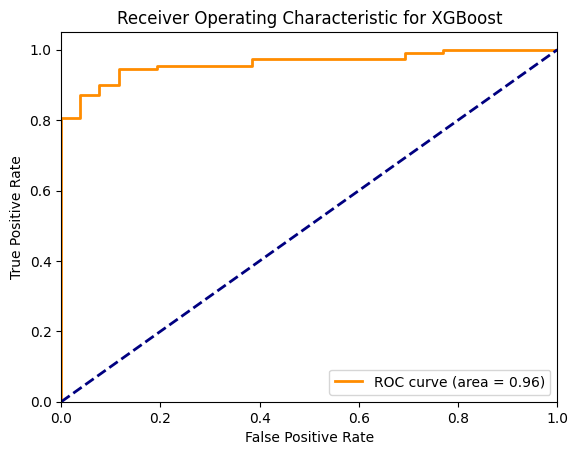

In [18]:
# ROC Curve
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()

MODEL - **KNN**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Parametre aralıklarını belirle
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan Distance, 2: Euclidean Distance
}

# Grid Search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# En iyi hiperparametre değerleri ile modeli oluşturun
best_knn_model = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                                      weights=best_params['weights'],
                                      p=best_params['p'])

best_knn_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapın
y_pred_best = best_knn_model.predict(X_test)

# Modelin performansını değerlendirin
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Best Model Accuracy:", accuracy_best)
print(classification_report(y_test, y_pred_best))

Best Hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Model Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

         0.0       0.64      0.69      0.67        26
         1.0       0.93      0.91      0.92       109

    accuracy                           0.87       135
   macro avg       0.78      0.80      0.79       135
weighted avg       0.87      0.87      0.87       135



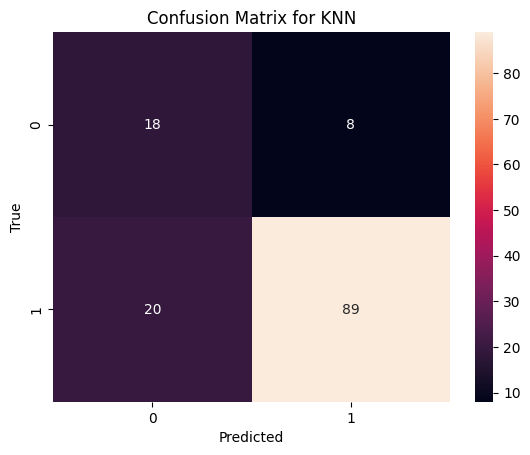

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for KNN')
plt.show()

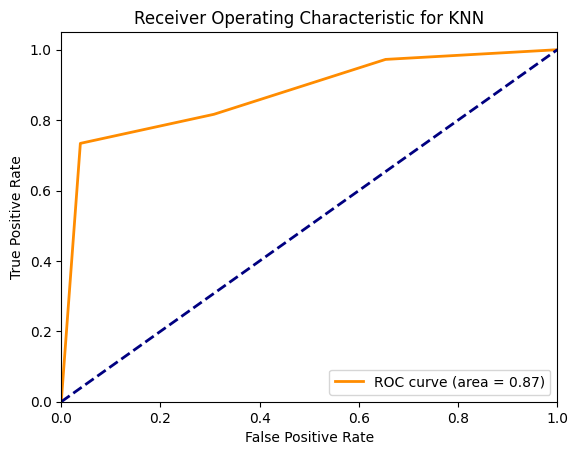

In [ ]:
# ROC Curve for knn
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN')
plt.legend(loc="lower right")
plt.show()

MODEL -XGBOOST - FINAL MODEL

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# XGBoost modelini oluşturun
xgb_model = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    scale_pos_weight=1,
    random_state=42
)

# Cross-validation için StratifiedKFold kullanarak modelin performansını değerlendirin
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Modeli eğitin (eval_set parametresi ile)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=True)

# Test seti üzerinde tahmin yapın
y_pred = xgb_model.predict(X_test)

Cross-Validation Scores: [0.89814815 0.90654206 0.90654206 0.89719626 0.86915888]
Mean Accuracy: 0.8955174800969194


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.51594	validation_1-logloss:0.49234
[1]	validation_0-logloss:0.50969	validation_1-logloss:0.48941
[2]	validation_0-logloss:0.50419	validation_1-logloss:0.48566
[3]	validation_0-logloss:0.49850	validation_1-logloss:0.48228
[4]	validation_0-logloss:0.49265	validation_1-logloss:0.47816
[5]	validation_0-logloss:0.48675	validation_1-logloss:0.47534
[6]	validation_0-logloss:0.48107	validation_1-logloss:0.47197
[7]	validation_0-logloss:0.47550	validation_1-logloss:0.46792
[8]	validation_0-logloss:0.47001	validation_1-logloss:0.46486
[9]	validation_0-logloss:0.46487	validation_1-logloss:0.46169
[10]	validation_0-logloss:0.45986	validation_1-logloss:0.45828
[11]	validation_0-logloss:0.45489	validation_1-logloss:0.45534
[12]	validation_0-logloss:0.44998	validation_1-logloss:0.45333
[13]	validation_0-logloss:0.44530	validation_1-logloss:0.45068
[14]	validation_0-logloss:0.44095	validation_1-logloss:0.44861
[15]	validation_0-logloss:0.43607	validation_1-logloss:0.44585
[1

In [24]:
# Modelin performansını değerlendirin
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9259259259259259
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81        26
         1.0       0.95      0.95      0.95       109

    accuracy                           0.93       135
   macro avg       0.88      0.88      0.88       135
weighted avg       0.93      0.93      0.93       135



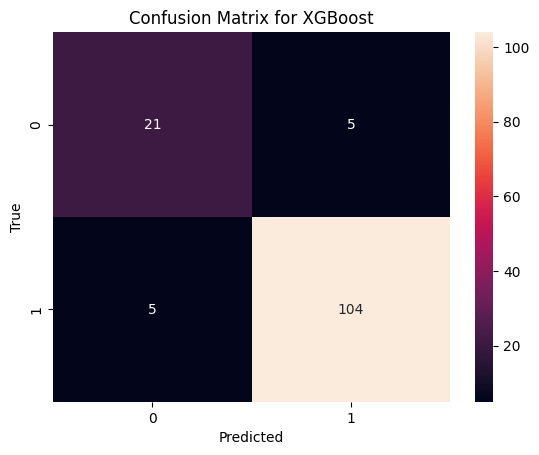

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost')
plt.show()

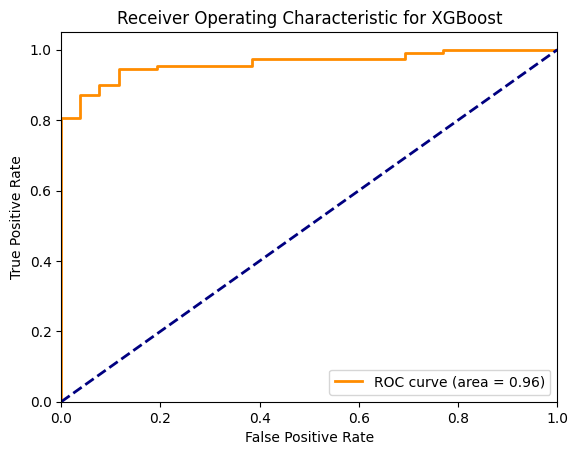

In [26]:
# ROC Curve
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()

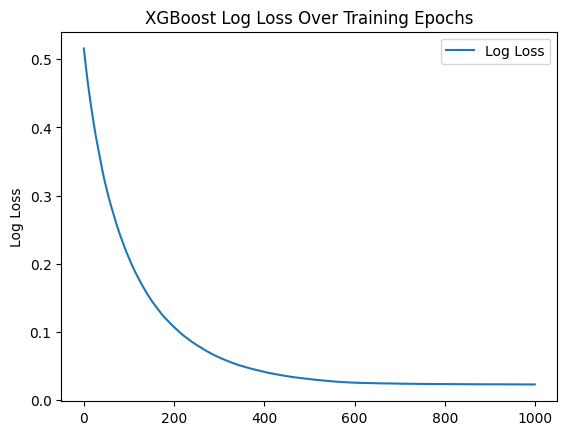

In [27]:
# Eğitim kayıplarını görselleştir
results = xgb_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Log Loss')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Training Epochs')
plt.show()

MODEL - **RANDOM FOREST**

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier modelini oluşturun
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Modeli eğitin
model.fit(X_train, y_train)

# Test seti üzerinde tahmin olasılıkları alın
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
# Accuracy hesaplayın
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8740740740740741
              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68        26
         1.0       0.93      0.92      0.92       109

    accuracy                           0.87       135
   macro avg       0.80      0.80      0.80       135
weighted avg       0.88      0.87      0.87       135



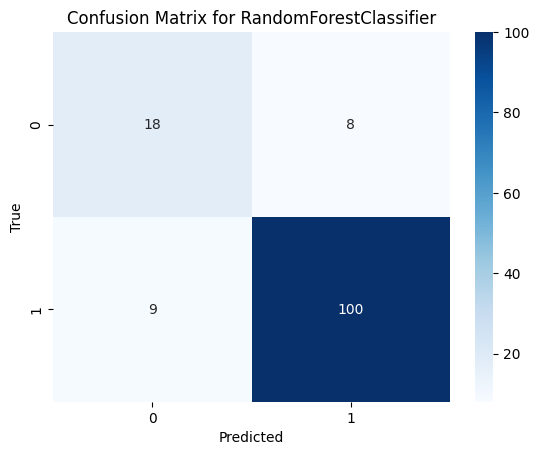

In [ ]:
# Confusion matrix for Random Forest
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()

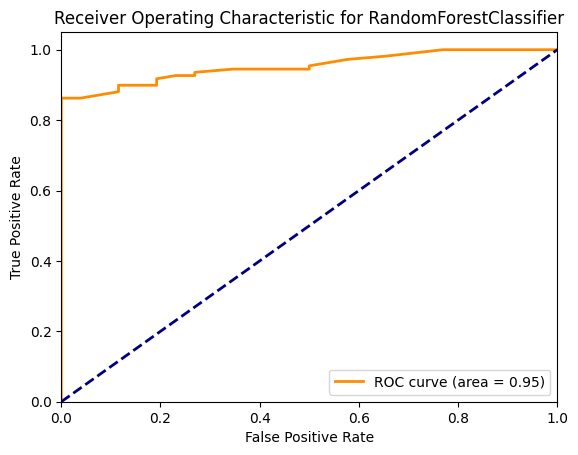

In [ ]:
# ROC Curve for Random Forest
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()